In [206]:
import tensorflow as tf
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

<h1>Ataque de Evasión</h1>

In [207]:
vulnerable_model = tf.keras.models.load_model("modelo_victima_lab6")

In [208]:
clasificador = KerasClassifier(
    model=vulnerable_model,
    clip_values=(0, 1),
)

In [209]:
#Ataque usando Gradiente Descendiente para generar imagenes adversariales
#Epsilon define que tan fuerte será el ataque:
#Debe haber un equilibrio entre la fuerza del ataque y la detección a simple vista que permita detectar que una imagen fue atacada

attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.3
)

In [210]:
# load images as numpy arrays from directory 'malimg_paper_dataset_imgs'
images = []
labels = []
main_directory = './malimg_paper_dataset_imgs'
for subfolder in os.listdir(main_directory):
    subfolder_path = os.path.join(main_directory, subfolder)
    if os.path.isdir(subfolder_path):
        # Iterate over files in the subfolder
        for file_name in os.listdir(subfolder_path):
            # Check if the file has the extension .png
            if file_name.endswith('.png'):
                file_path = os.path.join(subfolder_path, file_name)
                # Load the image using PIL
                image = Image.open(file_path)
                image = image.resize((256,256))
                image = image.convert('L')
                # Convert the image to a NumPy array and add it to the list
                image = np.array(image)
                #if (image_np.shape == (410, 512)):
                images.append([image.tolist()])
                labels.append(subfolder)

In [211]:
# encode categorical labels to integers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

images = np.array(images)
labels = np.array(labels)

In [212]:
#Dividir el dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [213]:
X_train = X_train.reshape(X_train.shape[0], 256, 256)
X_test = X_test.reshape(X_test.shape[0], 256, 256)

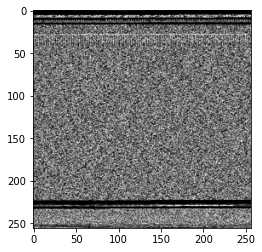

In [214]:
#Mostrar una imagen
plt.imshow(X_train[0], cmap='gray')

In [215]:
X_train = X_train.reshape(7471, 256, 256, 1)
X_test = X_test.reshape(1868, 256, 256, 1)

In [216]:
test_images_adv = attack_fgsm.generate(x=X_test)

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [217]:
#Evaluar los modelos
score_clean = vulnerable_model.evaluate(
    x=X_test, 
    y=y_test
    )

# Con adversarial
score_adv = vulnerable_model.evaluate(
    x=test_images_adv, 
    y=y_test
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.5f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.5f}")

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.48 vs adversarial set test loss: 0.50
Clean test set accuracy: 0.86831 vs adversarial test set accuracy: 0.86777


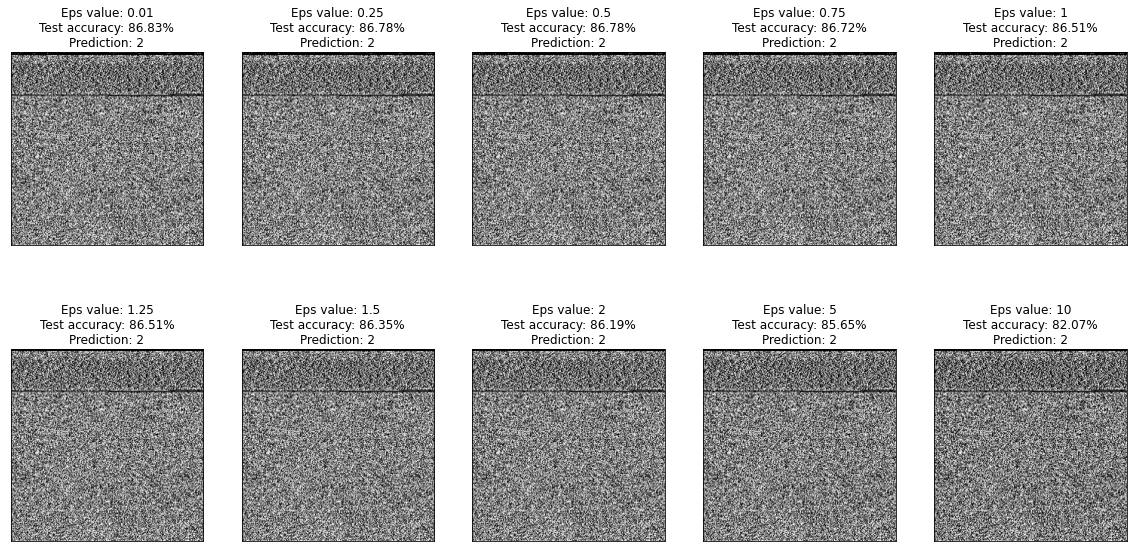

In [218]:
#Se prueba el accuracy para distintos valores de epsilon

# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 5, 10]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=clasificador, 
            eps=eps_to_try[counter]
            )
        
        # for each image in images_np, create an adversarial image
        adversarial_images = attack_fgsm.generate(x=X_test)

        # Showing the first adversarial image
        axes[i, j].imshow(X=adversarial_images[0], cmap="gray")

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # eliminar la segunda dimension de input_images
        adversarial_images = np.array(adversarial_images)

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = clasificador._model.evaluate(
            x=adversarial_images, 
            y=y_test
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(vulnerable_model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()